<div dir="rtl" align="center">
    <h2><strong> HW2: Avoid overfitting through Validation Set </strong></h2>
</div>

In [1]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from torchmetrics import Accuracy

import numpy as np

import matplotlib.pyplot as plt

### **Load train and test FasionMNIST dataset**

In [2]:
BATCH_size = 64

In [3]:
train_data = datasets.FashionMNIST(
    root="./Data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="./Data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_size,
    shuffle=True,
)

### **Construct Neural Network Regularized Model**

what we are going to use:
- l2 regularization
- Dropout
- BatchNormalization
- simpler model

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28**2, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(128, 10)
        )

    def forward(self, x):
        z = self.linear_layer(x)
        return z

### **Define Criterion and Optimizer**

In [5]:
EPOCHS = 12
LEARNING_RATE = 0.0001

### **Training & Evaluating NN Model**

In [7]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu' # for non-mac devices, we use 'cuda' instead of 'mps'
device = 'cpu' # we are going to use cpu here 
device

'cpu'

In [8]:
model = MLP().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
accuracy_fn = Accuracy(task="multiclass", num_classes=10)

train_loss_values, train_acc_values = [], []
test_loss_values, test_acc_values = [], []

for epoch in range(EPOCHS):
    train_batch_loss = 0
    train_batch_acc = 0
    for batch, (image, label) in enumerate(train_dataloader):
        image = image.to(device)
        label = label.to(device)
        
        model.train()
        logits = model(image)
        train_loss = loss_fn(logits, label)
        y_pred = nn.Softmax(dim=1)(logits).argmax(dim=1)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_batch_loss += train_loss.item()
        train_batch_acc += accuracy_fn(label, y_pred).item()

    train_loss_values.append(train_batch_loss / batch)
    train_acc_values.append(train_batch_acc / batch)

    test_batch_loss = 0
    test_batch_acc = 0
    model.eval()
    with torch.inference_mode():
        for batch, (image, label) in enumerate(test_dataloader):
            image = image.to(device)
            label = label.to(device)
            
            test_logits = model(image)
            test_loss = loss_fn(test_logits, label)
            test_y_pred = nn.Softmax(dim=1)(test_logits).argmax(dim=1)

            test_batch_loss += test_loss.item()
            test_batch_acc += accuracy_fn(label, test_y_pred).item()
            
        test_loss_values.append(test_batch_loss / batch)
        test_acc_values.append(test_batch_acc / batch)

    print("EPOCH:", epoch)
    print('train-loss', train_loss_values[epoch], end=" || ")
    print("train-acc", train_acc_values[epoch])
    print("test-loss", test_loss_values[epoch], end=" || ")
    print("test-acc", test_acc_values[epoch], end="\n\n")

EPOCH: 0
train-loss 1.007435991421835 || train-acc 0.6979889274279616
test-loss 0.5424549824152237 || test-acc 0.8239182692307693

EPOCH: 1
train-loss 0.5567264403261268 || train-acc 0.816135272145144
test-loss 0.44432693261366624 || test-acc 0.8513621794871795

EPOCH: 2
train-loss 0.48181304025484634 || train-acc 0.8367462646744931
test-loss 0.4229068329127935 || test-acc 0.8560697115384616

EPOCH: 3
train-loss 0.4502079004189248 || train-acc 0.8475520277481323
test-loss 0.39915109454439235 || test-acc 0.8659855769230769

EPOCH: 4
train-loss 0.4254187798105665 || train-acc 0.854105522945571
test-loss 0.38613323332407534 || test-acc 0.870292467948718

EPOCH: 5
train-loss 0.40850493299159574 || train-acc 0.8598085645677694
test-loss 0.3803917092199509 || test-acc 0.8719951923076923

EPOCH: 6
train-loss 0.39671809813892317 || train-acc 0.8632604055496265
test-loss 0.3726355208036227 || test-acc 0.8746995192307693

EPOCH: 7
train-loss 0.382200379079663 || train-acc 0.8688133671291356
test

### **Plot train and validation losses**

In [ ]:
def learning_curve_plotter(train_loss_values, test_loss_values, EPOCH) :
    # plot the learning curves
    plt.plot(np.arange(1, EPOCH+1), train_loss_values, label="Train loss")
    plt.plot(np.arange(1, EPOCH+1), test_loss_values, label="Test loss")
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend();

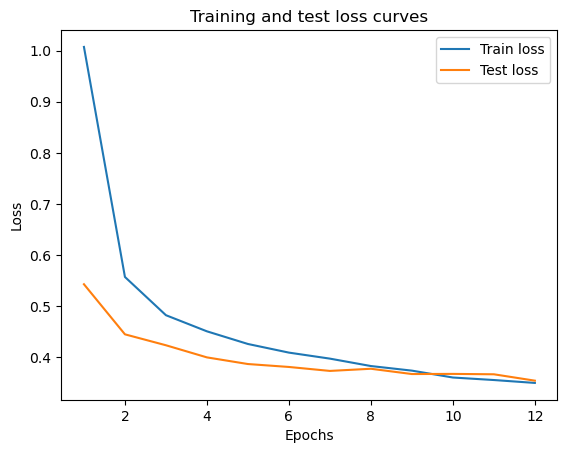

In [9]:
learning_curve_plotter(train_loss_values, test_loss_values, EPOCHS)

___

## Evaluation

In [10]:
def eval(model, dataloader, loss_fn, accuracy_fn, device="cpu"):
    model.eval()
    batch_accuracy = 0
    batch_loss = 0
    with torch.inference_mode():
        for batch, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            y_pred = nn.Softmax(dim=1)(logits)
            loss = loss_fn(logits, labels)
            acc = accuracy_fn(y_pred.argmax(dim=1), labels).item()

            batch_loss += loss.item()
            batch_accuracy += acc

    return {
        "model": model.__class__.__name__,
        "loss": (batch_loss / (batch+1)),
        "acc": (batch_accuracy / (batch+1)),
    }

In [11]:
eval(model, test_dataloader, loss_fn, accuracy_fn, device='cpu')

{'model': 'MLP', 'loss': 0.35091301571032046, 'acc': 0.8742038216560509}